In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [7]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test) %>% (kaggle.house$na$fixAll)

dataset <- 
    df.combined %>% 
    filter(dataSource == "train") %>% 
    mutate(sale_price_log = log(SalePrice))

In [147]:
combine.OverallQual <- function (df) {
    df %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4) ~ 'A',
            OverallQual %in% c(5, 6) ~ 'B',
            OverallQual %in% c(7, 8) ~ 'C',
            TRUE ~ 'D'
        )
    )
}

combine.Neighborhood <- function (df) {
    df %>%
    group_by(Neighborhood) %>%
    mutate(
        hood.avg.sale.price = median(SalePrice),
        hood.level = case_when(
            hood.avg.sale.price < 130e3 ~ '1',
            hood.avg.sale.price >= 130e3 & hood.avg.sale.price < 160e3 ~ '2',
            hood.avg.sale.price >= 160e3 & hood.avg.sale.price < 195e3 ~ '3',
            hood.avg.sale.price >= 195e3 & hood.avg.sale.price < 260e3 ~ '4',
            TRUE ~ '5'
        )
    )
}

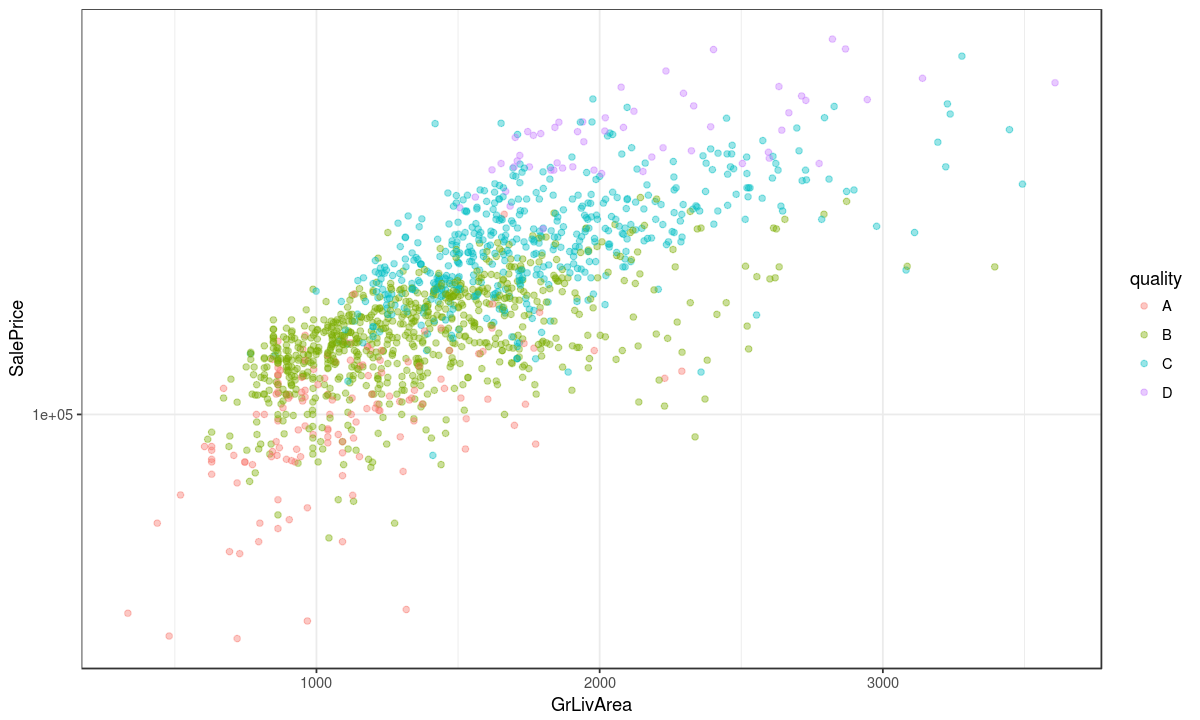

In [148]:
options(repr.plot.width = 10, repr.plot.height = 6)

dataset %>%
    filter(SalePrice < 6e5, GrLivArea < 4e3) %>%
    (combine.OverallQual) %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=quality), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

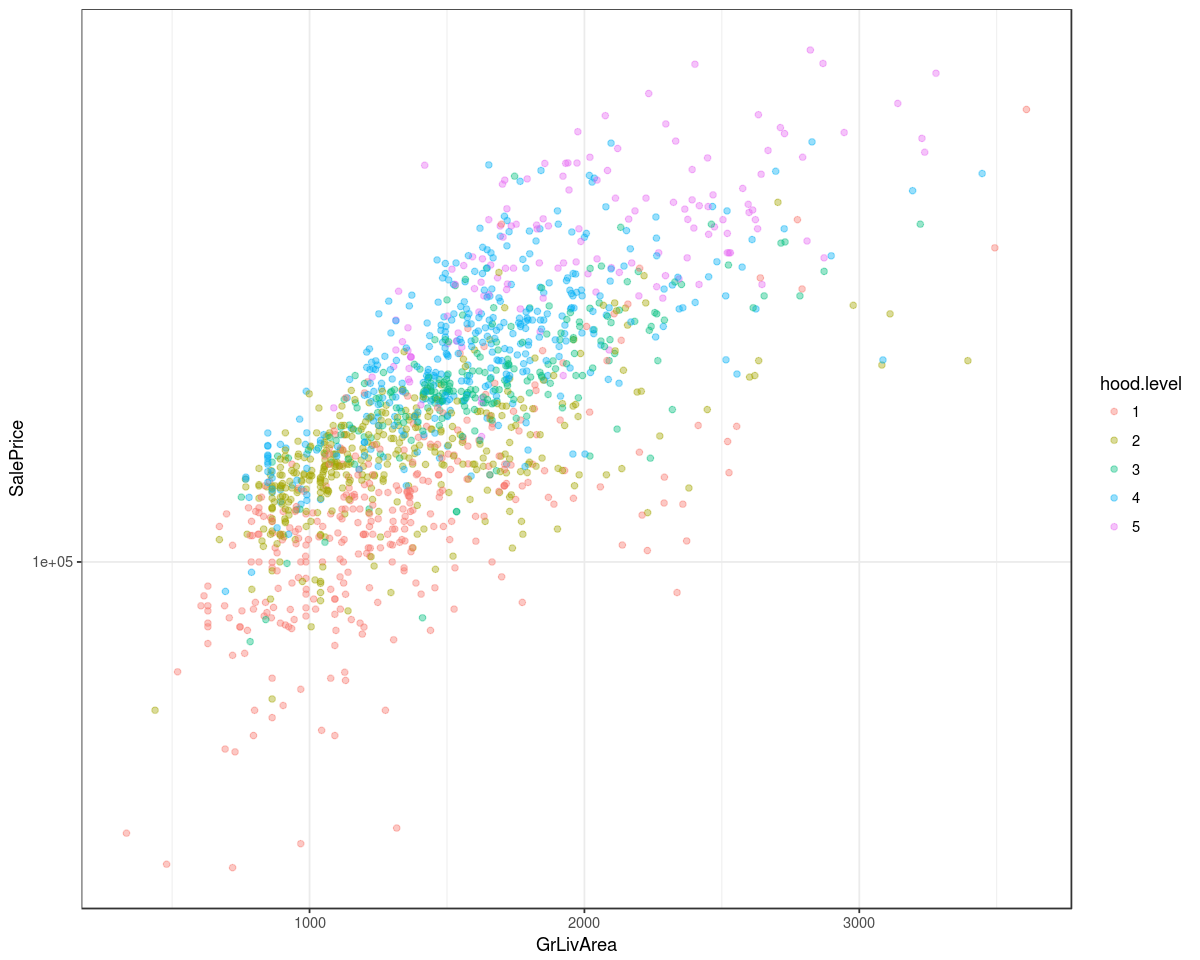

In [149]:
options(repr.plot.width = 10, repr.plot.height = 8)

df.Neighborhood <- 
    dataset %>%
    select(Neighborhood, SalePrice, GrLivArea) %>%
    (combine.Neighborhood)

df.Neighborhood %>%
    filter(SalePrice < 6e5, GrLivArea < 4e3) %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=hood.level), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

hood.level,Neighborhood,n,mi,ma,check,n.hood.level,ncum,id
1,MeadowV,17,88000,88000,TRUE,341,17,1
1,IDOTRR,37,103000,103000,TRUE,341,54,2
1,BrDale,16,106000,106000,TRUE,341,70,3
1,OldTown,113,119000,119000,TRUE,341,183,4
1,Edwards,100,121750,121750,TRUE,341,283,5
1,BrkSide,58,124300,124300,TRUE,341,341,6
2,Sawyer,74,135000,135000,TRUE,384,415,7
2,Blueste,2,137500,137500,TRUE,384,417,8
2,SWISU,25,139500,139500,TRUE,384,442,9
2,NAmes,225,140000,140000,TRUE,384,667,10


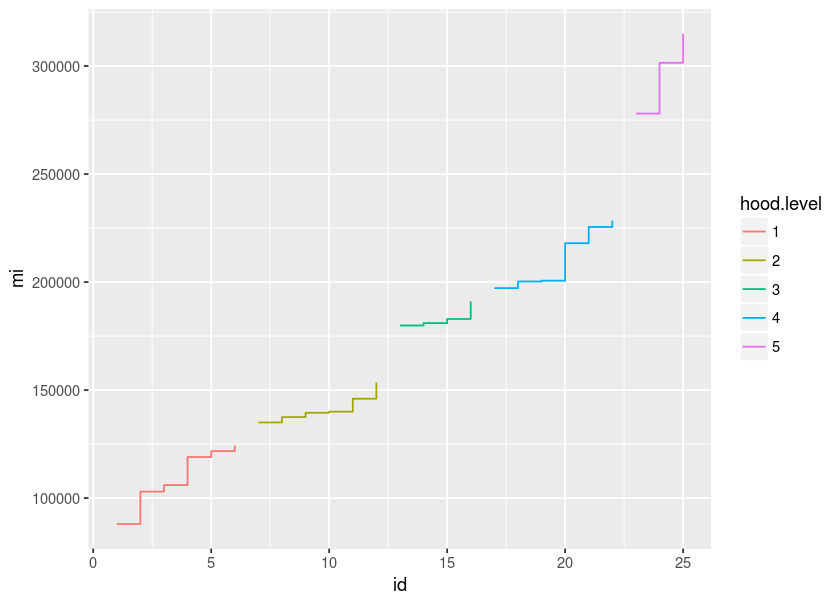

In [135]:
options(repr.plot.width = 7, repr.plot.height = 5)

tmp <- df.Neighborhood %>%
    group_by(hood.level, Neighborhood) %>%
    summarise(
        n = n(),
        mi = min(hood.avg.sale.price),
        ma = max(hood.avg.sale.price),
        check = mi == ma
    ) %>%
    mutate(
        n.hood.level = sum(n)
    ) %>%
    arrange(mi) %>%
    ungroup %>%
    mutate(
        ncum = cumsum(n),
        id = row_number()
    )

tmp

tmp %>%
    ggplot() +
    geom_step(aes(id, mi, color=hood.level))

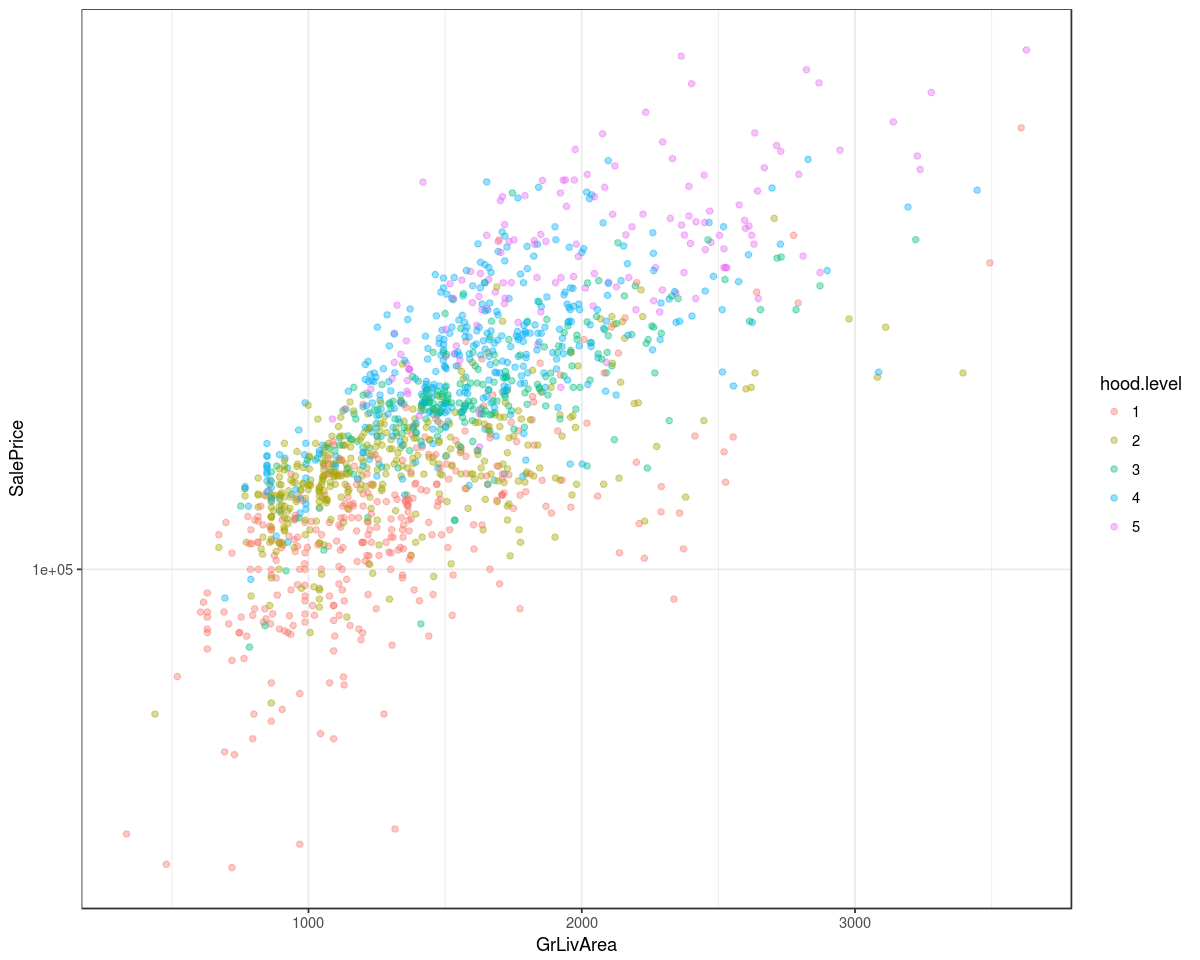

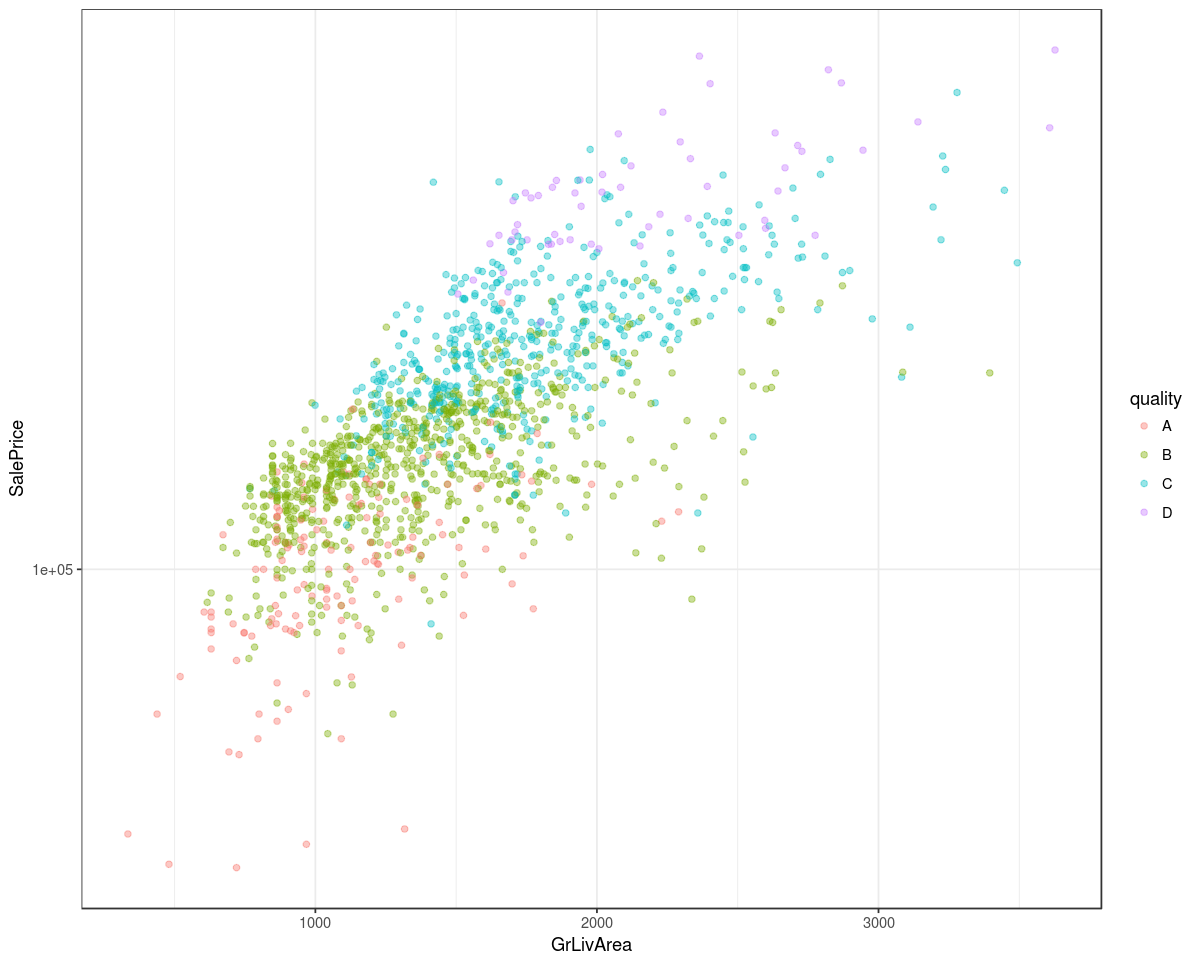

In [150]:
options(repr.plot.width = 10, repr.plot.height = 8)

df.final <- dataset %>%
    select(SalePrice, OverallQual, Neighborhood, GrLivArea) %>%
    filter(GrLivArea < 4e3) %>%
    (combine.OverallQual) %>%
    (combine.Neighborhood) %>%
    ungroup %>%
    select(SalePrice, quality, hood.level, GrLivArea)

df.final %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=hood.level), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

df.final %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=SalePrice, colour=quality), alpha=0.4) +
    scale_y_log10() +
    theme_bw()

In [151]:
df.final %>%
    group_by(hood.level, quality) %>%
    summarise(
        avg.price = median(SalePrice),
        n = n()
    )

hood.level,quality,avg.price,n
1,A,95000,95
1,B,119900,211
1,C,158250,30
1,D,325000,3
2,A,118500,38
2,B,140000,321
2,C,205000,25
3,A,107000,3
3,B,175500,111
3,C,197000,113
